## Setting up the environment


In [1]:
import gymnasium as gym
import text_flappy_bird_gym

if __name__ == "__main__":
    env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

# Implement SARSA method


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [13]:
class SARSA:
    def __init__(self, space_size, action_size, gamma=1):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """
        # the discount factor
        self.gamma = gamma

        # size of system
        self.space_size = space_size  # as tuple
        self.action_size = action_size

        # where to save returns
        self.Qvalues = np.zeros((*self.space_size, self.action_size))

    def get_action_epsilon_greedy(self, s):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()

        if ran < self.epsilon:
            prob_actions = np.ones(self.action_size) / self.action_size

        else:
            best_value = np.max(self.Qvalues[(*s,)])

            best_actions = self.Qvalues[(*s,)] == best_value

            prob_actions = best_actions / np.sum(best_actions)

        a = np.random.choice(self.action_size, p=prob_actions)
        return a

    def single_step_update(self, s, a, r, new_s, new_a, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        self.et[(*s, a)] += 1

        # If we reached the terminal state
        if done:
            deltaQ = r + 0 - self.Qvalues[(*s, a)]
            self.Qvalues += self.lr_v * deltaQ * self.et

        else:
            deltaQ = (
                r + self.gamma * self.Qvalues[(*new_s, new_a)] - self.Qvalues[(*s, a)]
            )

            self.Qvalues += self.lr_v * deltaQ * self.et
            self.et *= self.gamma * self.lambda_

    def train(
        self,
        n_episodes=10000,
        lambda_=0,
        tstar=None,
        epsilon_0=0.2,
        k_epsilon=0,
        lr_v0=0.15,
        k_lr=0,
    ):
        """
        This function trains the agent using n_episodes.
        The default parameters use constant learning rate and epsilon (k = 0 in both cases)
        Otherwise a decaying rate is implemented after a starting point t0 (see README for more details)
        Similarly the default implements a TD(0) evaluation procedure (lambda = 0)
        """

        Actions = [i for i in range(self.action_size)]
        self.n_episodes = n_episodes

        # Add the following attributes to the class
        self.performance_traj = np.zeros(n_episodes)  # To store cumulative reward at every game

        self.et = np.zeros((*self.space_size, self.action_size))
        self.lambda_ = lambda_

        # Parameters for epsilon decay
        self.epsilon_0 = epsilon_0  # Needed to name the plots
        self.epsilon = epsilon_0  # Needed to keep track of current epsilon
        self.k_epsilon = k_epsilon

        # Parameters for learning rate decay
        self.lr_v0 = lr_v0
        self.lr_v = lr_v0
        self.k_lr = k_lr

        if tstar is None:
            tstar = 2.5 * n_episodes

        count = 0  # counter variable needed to see when to start decaying rates

        # Run over episodes
        for i in range(n_episodes):
            done = False
            s, info = env.reset()
            a = self.get_action_epsilon_greedy(s)
            act = Actions[a]

            count_actions = 0

            while not done:
                count += 1
                count_actions += 1 # To stop the game at some point

                # Perform one "step" in the environment
                new_s, r, done, _, info = env.step(act)

                # Keep track of rewards for one episode
                self.performance_traj[i] += r

                # Choose new action index
                new_a = self.get_action_epsilon_greedy(new_s)
                act = Actions[new_a]
                # Single update with (S, A, R', S', A')
                self.single_step_update(s, a, r, new_s, new_a, done)

                if count > tstar:
                    self.epsilon = epsilon_0 / (1.0 + self.k_epsilon * (count - tstar) ** 1.05)
                    self.lr_v = lr_v0 / (1 + self.k_lr * (count - tstar) ** 0.75)

                a = new_a
                s = new_s

                if count_actions > 30000:
                    done = True

    def plot_traj(self, cumulative=True, local=False, save_img=False, save_traj=False):
        title = "SARSA"

        plot_indexes = np.arange(0, self.n_episodes + 1, 20, dtype=int)
        plot_indexes[-1] = plot_indexes[-1] - 1

        plt.plot(plot_indexes, self.performance_traj[plot_indexes])

        if cumulative:
            cumulative_mean = np.cumsum(self.performance_traj) / np.arange(1, len(self.performance_traj) + 1)
            plt.plot(plot_indexes, cumulative_mean[plot_indexes], label="Cumulative mean")
        if local:
            window_size = 100
            local_mean_SARSA = np.convolve(self.performance_traj, np.ones(window_size) / window_size, mode="valid")
            plt.plot(plot_indexes[plot_indexes < local_mean_SARSA.shape[0]],
                     local_mean_SARSA[plot_indexes[plot_indexes < local_mean_SARSA.shape[0]]],
                     label=" Local Mean", color = 'red')
            
        plt.xlabel("Episode")
        plt.ylabel("Episode reward")
        plt.legend()
        plt.suptitle(f"{title} control cumulative rewards")

        plt.title(f"$\epsilon_0$ = {self.epsilon_0}, $k_\epsilon$ = {self.k_epsilon}, $\\alpha_0$ = {self.lr_v0}, $k_{{\\alpha}}$ = {self.k_lr}, $\lambda$ = {self.lambda_}")
        plt.tight_layout()

        if save_img:
            name = (
                "Plots/SARSA_plots/SARSA_lambda_" + str(self.lambda_)
                + "_k_alpha_"
                + str(self.k_lr)
                + "k_epsilon"
                + str(self.k_epsilon)
                + ".png"
            )
            plt.savefig(name)
        plt.show()

        if save_traj:
            name = (
                "Trajectories/SARSA_trajectories/SARSA_lambda_" + str(self.lambda_)
                + "_k_alpha_"
                + str(self.k_lr)
                + "k_epsilon"
                + str(self.k_epsilon)
                + ".txt"
            )
            array_str = " ".join(str(element) for element in self.performance_traj)
            file = open(name, 'w+')
            file.write(array_str)
            file.close()
    
    def plot_best_actions(self):
        """
        Function to plot which is the best action for each state
        """
        dimx = self.Qvalues.shape[0]
        dimy= self.Qvalues.shape[1]
        newQ = np.zeros((dimx, dimy))
        for x in range(dimx):
            for y in range(dimy):
                if(self.Qvalues[x][y][0] == 0.0 and self.Qvalues[x][y][1] == 0.0):
                    newQ[x][y] = -1
                elif(self.Qvalues[x][y][0] > self.Qvalues[x][y][1]):
                    newQ[x][y] = 0
                else:
                    newQ[x][y] = 1
        finalQ = np.zeros((self.Qvalues.shape[0],self.Qvalues.shape[1]))
        for i in range(self.Qvalues.shape[0]):
            for j in range(self.Qvalues.shape[1]):
                if(j <= 11):
                    finalQ[i][j+10] = newQ[i][j]
                else:
                    finalQ[i][j-12] = newQ[i][j]
        finalQ = finalQ.transpose()

        xx = np.arange(0, 15, 1)
        yy = np.arange(-11, 12, 1)
        # Create plot
        fig = plt.figure(figsize=(10, 10))
        plt.xticks(xx)
        plt.yticks(yy)
        im = plt.imshow(finalQ, extent=[0, 14, -11, 11])
        plt.grid(color='w', linestyle='-', linewidth=1)
        labels = ['Not visited', '0 (Idle)', '1 (Flap)']
        colorbar = plt.colorbar(im, ticks=[-1, 0, 1])
        colorbar.ax.set_yticklabels(['Not visited', '0 (Idle)', '1 (Flap)'])



In [4]:
observation_space = (env.observation_space[0].n, env.observation_space[1].n)

In [5]:
n_episodes = 10000

In [6]:
lambdas = [0.0, 0.2, 0.5, 0.8]
k_epsilons = [0.00005, 0.0005, 0.005, 0.05]
k_lrs = [0.00003, 0.0003, 0.003, 0.03]

j 5e-05 l 3e-05


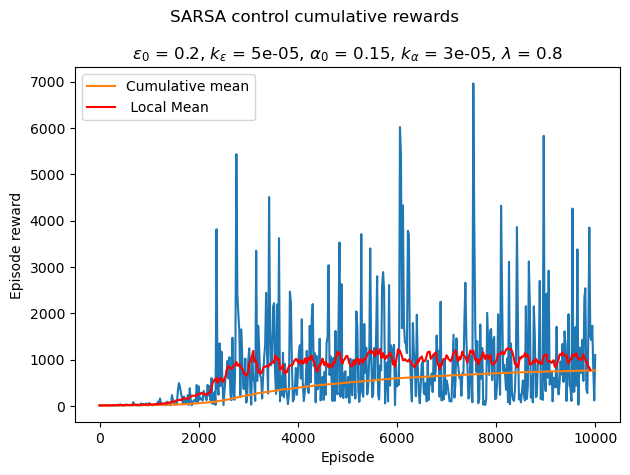

j 5e-05 l 0.0003


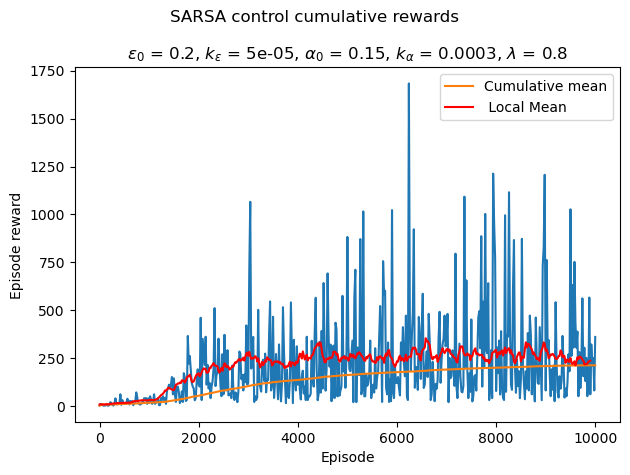

j 5e-05 l 0.003


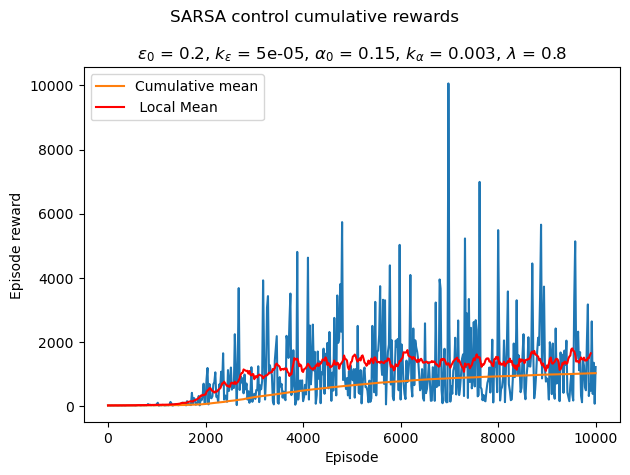

j 5e-05 l 0.03


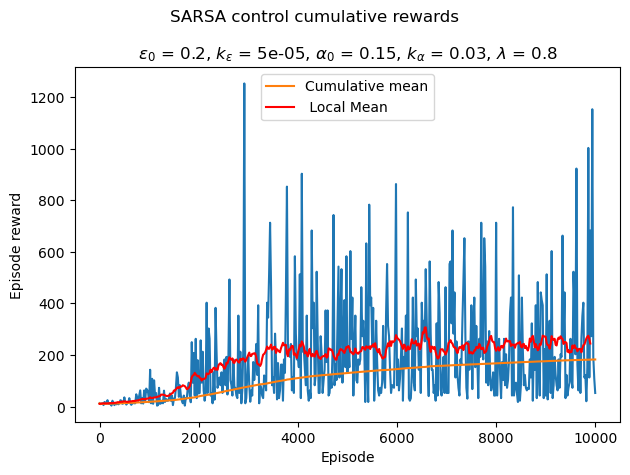

j 0.0005 l 3e-05


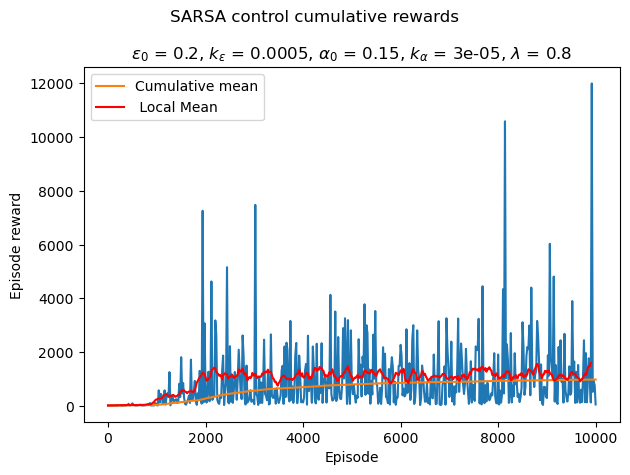

j 0.0005 l 0.0003


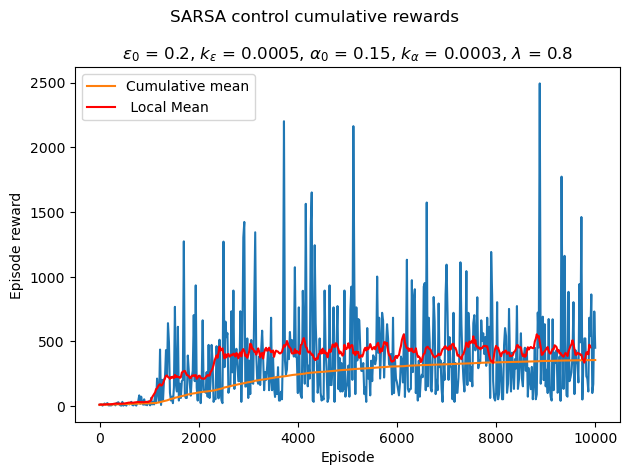

j 0.0005 l 0.003


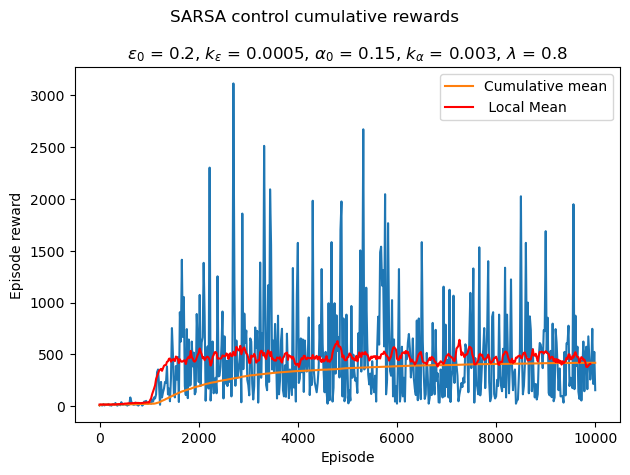

j 0.0005 l 0.03


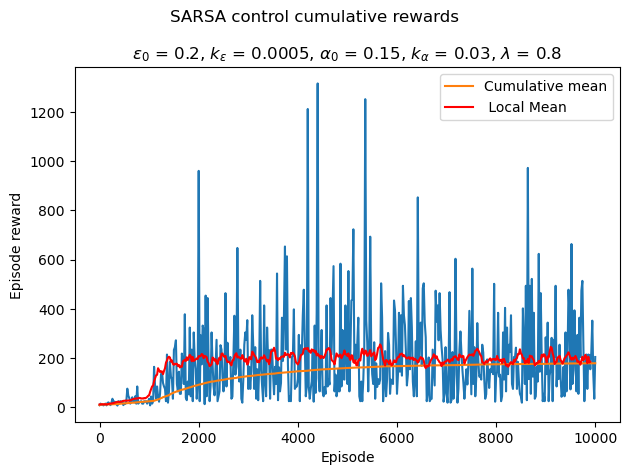

j 0.005 l 3e-05


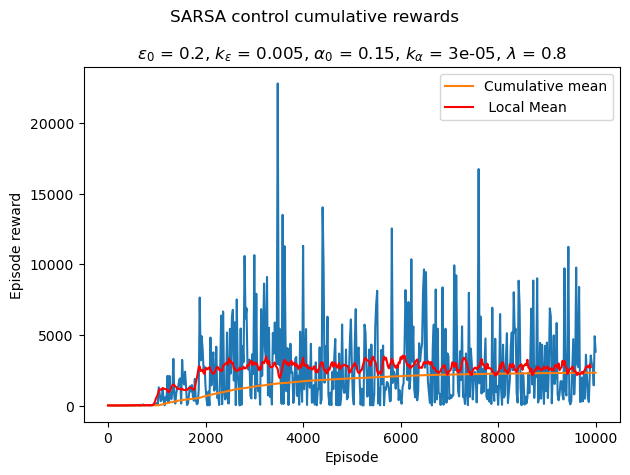

j 0.005 l 0.0003


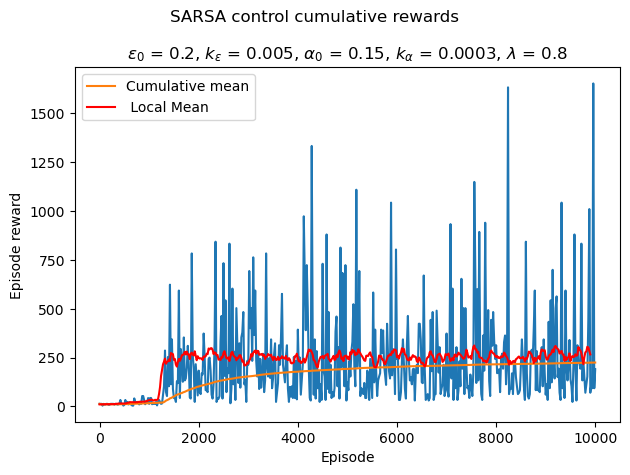

j 0.005 l 0.003


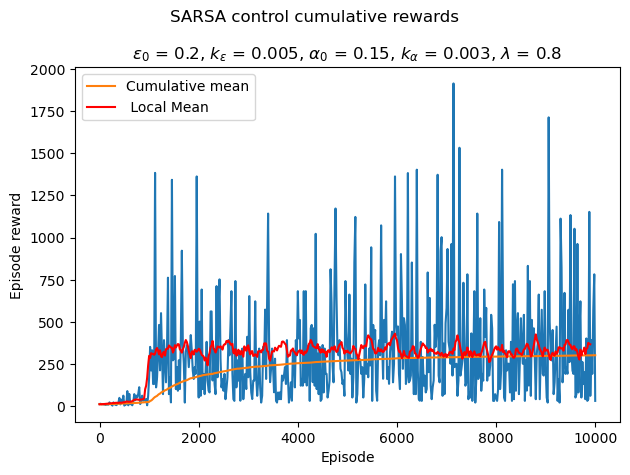

j 0.005 l 0.03


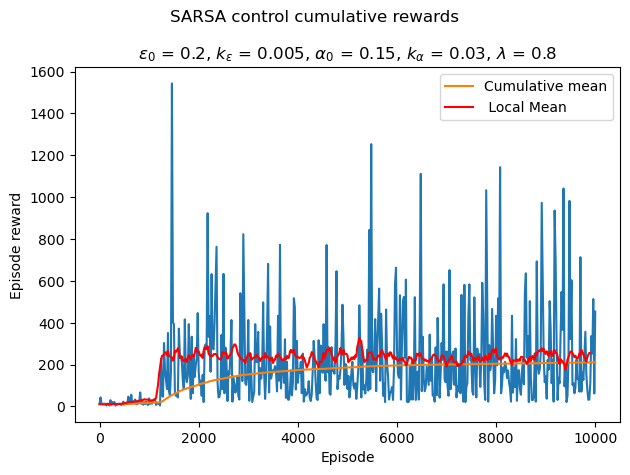

j 0.05 l 3e-05


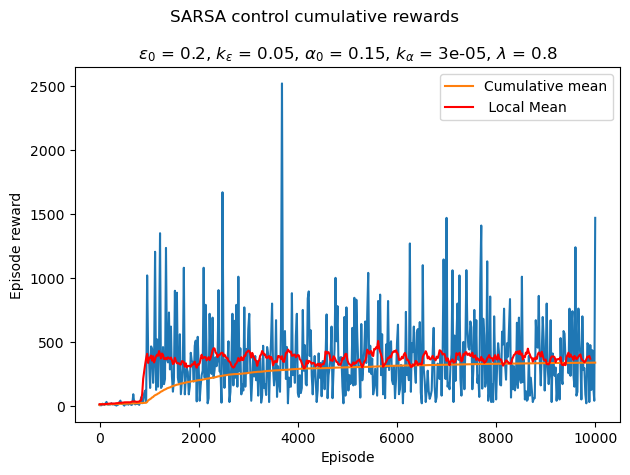

j 0.05 l 0.0003


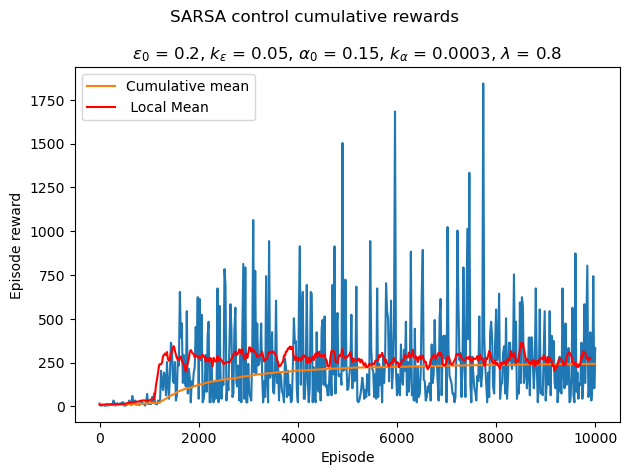

j 0.05 l 0.003


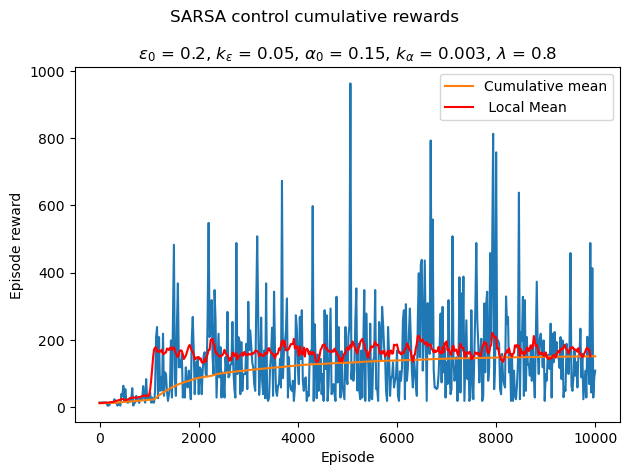

j 0.05 l 0.03


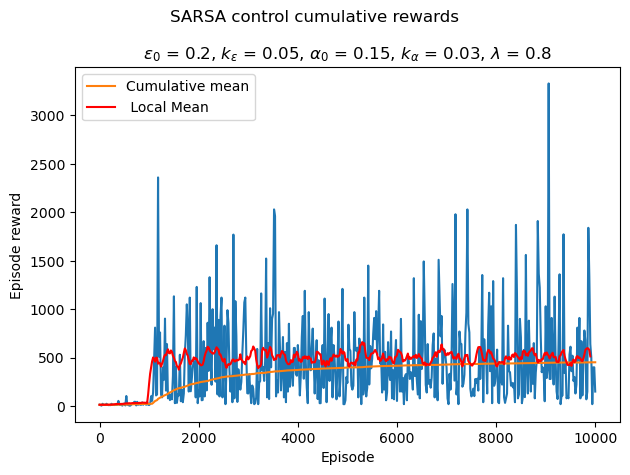

In [15]:
lambda_ = lambdas[3]
for j in k_epsilons:
    for l in k_lrs:
        print("j", j, "l", l)
        sarsa = SARSA(space_size=observation_space, action_size=2, gamma=1)
        sarsa.train(n_episodes=n_episodes, lambda_=lambda_, k_epsilon=j, k_lr=l)
        sarsa.plot_traj(cumulative=True, local=True, save_img=True, save_traj=True)

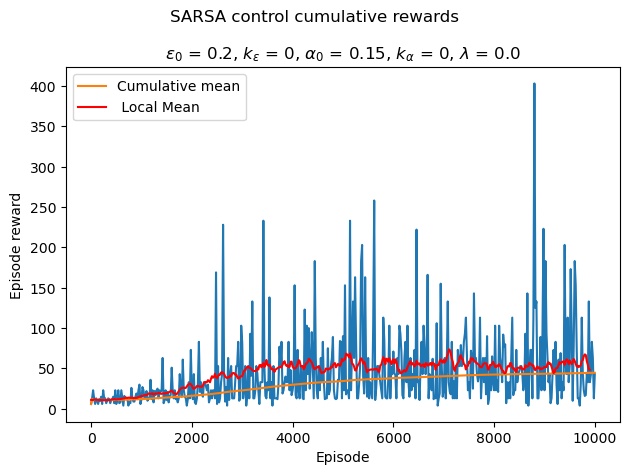

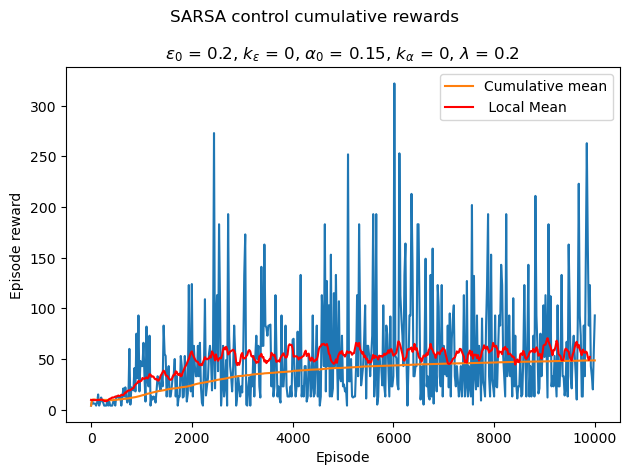

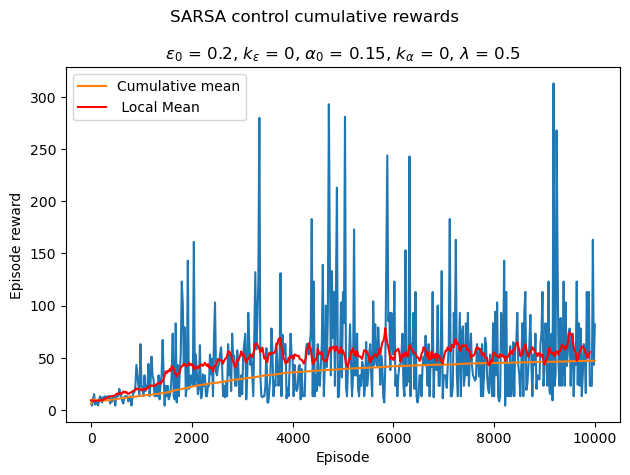

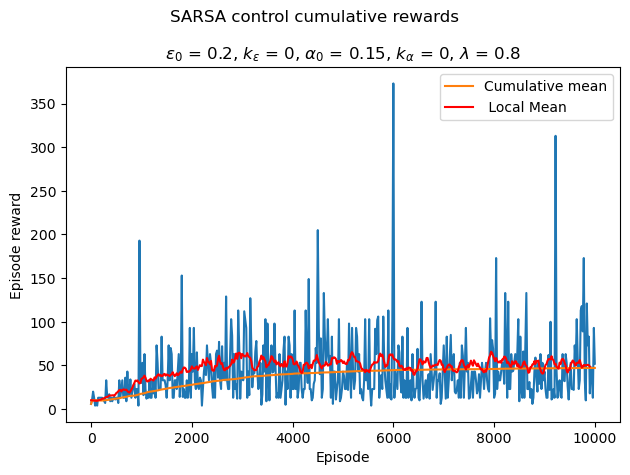

In [16]:
for i in lambdas:
   "Last run to include case with no decaying"
   k_e = 0
   k_lr = 0
   sarsa = SARSA(space_size=observation_space, action_size=2, gamma=1)
   sarsa.train(n_episodes=n_episodes, lambda_=i, k_epsilon=k_e, k_lr=k_lr)
   sarsa.plot_traj(cumulative=True, local=True, save_img=True, save_traj=True)